# Basics of FFT estimators for P1D

This is a toy example, but to make it easier to connect with reality I will try to use units and values similars to what we believe is the real universe. 

We don't need to specify units in this toy example, but I will use values that would roughly correspond to Mpc in a real data analysis.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Define the FFT grid

In [2]:
# number of pixels (powers of two are usually good)
N=2**10
# number of Fourier modes
NF=int(N/2+1)
# skewer length
L=500
# pixel width 
dx = L/N
print('dx=',dx)
# Wavenumbers for the generated Fourier modes, specified by the grid length and resolution
k = np.fft.rfftfreq(N)*2*np.pi/dx
q = np.fft.fftfreq(N)*2*np.pi/dx

dx= 0.48828125


In [3]:
print('Nk =',k.shape)
print('Delta k =',k[1],2*np.pi/L)
print('k_Ny = ',k[-1],np.pi/dx)

Nk = (513,)
Delta k = 0.012566370614359173 0.012566370614359173
k_Ny =  6.433981754551897 6.433981754551897


In [4]:
print('Nk =',q.shape)
print('Delta k =',q[1],2*np.pi/L)
print('k_Ny = ',-q[N//2],np.pi/dx)

Nk = (1024,)
Delta k = 0.012566370614359173 0.012566370614359173
k_Ny =  6.433981754551897 6.433981754551897


In [5]:
if N<10:
    print(k)
    print(q)

Setup the random number generator

In [6]:
# random seed
seed=1234
# setup random number generator using seed
gen = np.random.default_rng(seed)
# test the random number generator
gen.normal(size=1)

array([-1.60383681])

### Input power spectrum

The power spectrum will deteremine how much structure is there as a funciton of scale

In [7]:
def true_p1d(k,P0=1.0,k0=1,kF=10):
    """Define here your favorite power spectrum."""

    # white noise at low-k
    P = P0*np.ones_like(k)

    # small enhancement at low-k
    P *= (1+k/k0)
    
    # suppressed at k0
    P *= 1/(1+(k/k0)**2)

    # further suppressed with a Gaussian at kF=10
    P *= np.exp(-(k/kF)**2)
    
    return P

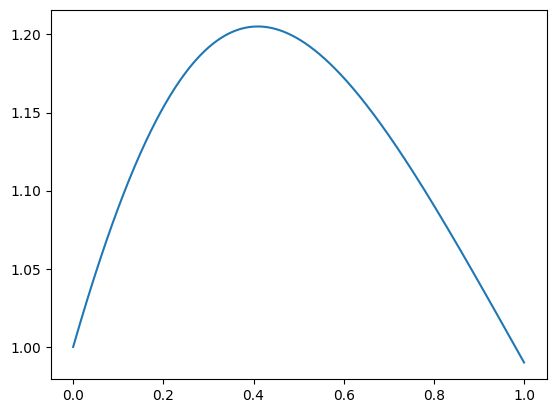

In [8]:
# linear plot
kplot=np.linspace(0,1,1000)
plt.plot(kplot,true_p1d(kplot))

(0.0001, 2)

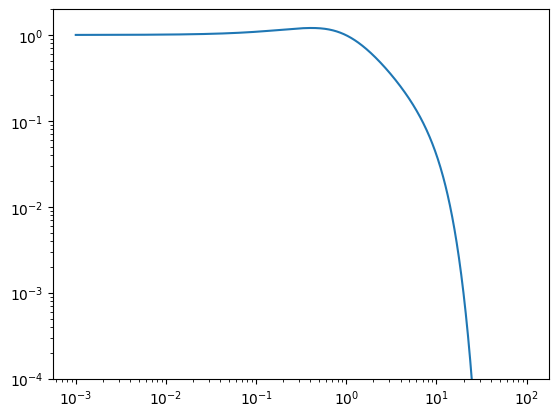

In [9]:
# log spacing plot
kplot=np.logspace(-3,2,1000)
plt.loglog(kplot,true_p1d(kplot))
plt.ylim(0.0001,2)

### Generate random Gaussian skewers

Start by generating random Fourier modes

In [10]:
def get_gaussian_modes(gen,new_seed=None,debug=False):
    """Generate Gaussian random numbers for the Fourier modes of the grid."""

    if new_seed:
        new_gen = np.random.default_rng(new_seed)
    else:
        new_gen = gen

    if debug:
        print(new_gen.normal(size=1))
    
    # get frequencies (wavenumbers)
    k = np.fft.rfftfreq(N)*2*np.pi/dx
    # get power evaluated at each k
    P = true_p1d(k)

    # generate random Fourier modes
    modes = np.empty(NF, dtype=complex)
    modes[:].real = new_gen.normal(size=NF)
    modes[:].imag = new_gen.normal(size=NF)
    
    # normalize to desired power (and enforce real for i=0, i=NF-1)
    modes[0] = modes[0].real * np.sqrt(P[0])
    modes[-1] = modes[-1].real * np.sqrt(P[-1])
    modes[1:-1] *= np.sqrt(0.5*P[1:-1])    
    
    return modes

In [11]:
modes=get_gaussian_modes(gen,new_seed=1,debug=True)

[0.34558419]


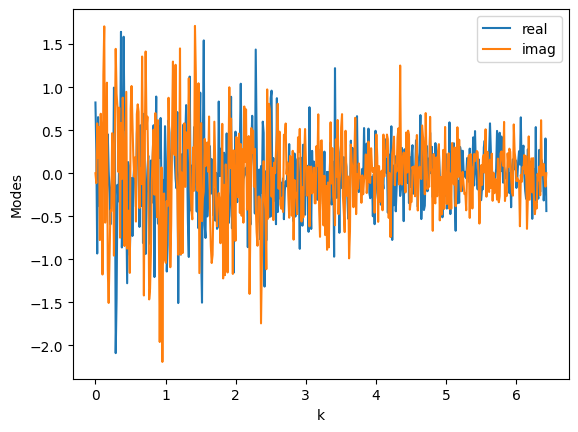

In [12]:
plt.plot(k,modes.real,label='real')
plt.plot(k,modes.imag,label='imag')
plt.xlabel('k')
plt.ylabel('Modes')
#plt.title('Gaussian Fourier modes (real part)')
plt.legend()

Now FFT them to get the skewers

In [13]:
def get_field(modes):
    """Given a set of Fourier modes, compute inverse Fourier transform to get a field"""
    if NF != len(modes):
        print('size mismatch',NF,len(modes))
        raise SystemExit
    # inverse FFT to get (normalized) delta field
    delta = np.fft.irfft(modes) * np.sqrt(N/dx)
    return delta

def get_modes(deltas):
    """Given a delta field, return set of Fourier modes using FFT"""
    if N != len(deltas):
        print('size mismatch',N,len(deltas))
        raise SystemExit
    # inverse FFT to get (normalized) delta field
    modes = np.fft.rfft(deltas) / np.sqrt(N/dx)
    new_deltas = np.fft.irfft(modes) * np.sqrt(N/dx)
    return modes

def get_gaussian_field(gen,new_seed=None,debug=False):
    """Generate a set of random Fourier modes, and use them to get a field"""
    modes = get_gaussian_modes(gen=gen,new_seed=new_seed,debug=debug)
    return get_field(modes)

In [14]:
modes=get_gaussian_modes(gen=gen,new_seed=1,debug=True)

[0.34558419]


In [15]:
# Inverse Fourier transform to get the density fluctuations
deltas=get_field(modes)

In [16]:
# Test that we recover the modes
new_modes=get_modes(deltas)
print(max(modes-new_modes))

(4.440892098500626e-16+1.6653345369377348e-16j)


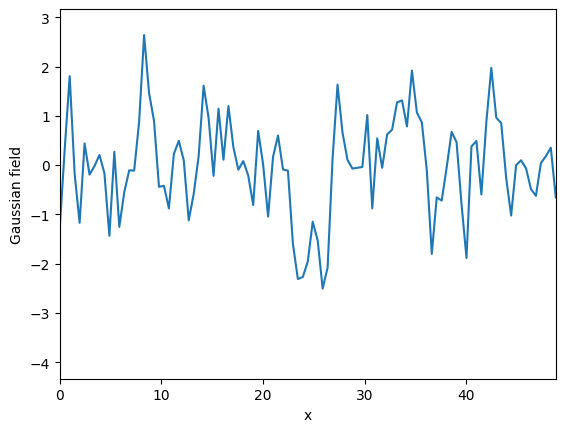

In [17]:
# position of cells in skewers
x = dx*np.arange(N)
plt.plot(x,deltas)
if N>100:
    plt.xlim(0.0,100.0*dx)
plt.xlabel('x')
plt.ylabel('Gaussian field');

### Check agreement with input power

The squared amplitude of the Fourier modes should (on average!) agree with the input power spectrum

Text(0, 0.5, 'P(k)')

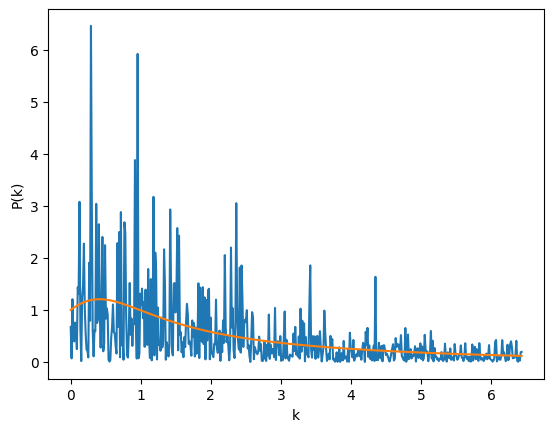

In [18]:
plt.plot(k,abs(modes)**2)
plt.plot(k,true_p1d(k))
plt.xlabel('k')
plt.ylabel('P(k)')

The plot above is very noisy, be cause the amplitude of each Fourier mode itself is a random number. We could average multiple realisations (multiple fake universes), but we could also compute the average power over neighbouring wavenumbers.

In [19]:
def binned_power(k,Pk,Nrebin):
    if NF != len(Pk):
        print('size mismatch',NF,len(Pk))
        raise SystemExit
    Nk=int(NF/Nrebin)
    #print('NF',NF)
    #print('Nk',Nk)
    binned_k = np.zeros(Nk)
    binned_Pk = np.zeros(Nk)
    binned_var_Pk = np.zeros(Nk)
    for i in range(0,NF):
        ibin=int(i/Nrebin)
        if ibin==Nk:
            continue
        binned_k[ibin] += k[i]
        binned_Pk[ibin] += Pk[i]
        binned_var_Pk[ibin] += Pk[i]*Pk[i] 
    for ibin in range(0,Nk):
        binned_k[ibin] /= Nrebin
        binned_Pk[ibin] /= Nrebin
        # variance in binned power
        binned_var_Pk[ibin] /= (Nrebin-1)
        binned_var_Pk[ibin] -= binned_Pk[ibin]*binned_Pk[ibin]
        # error in mean of binned power
        binned_var_Pk[ibin] /= Nrebin
    return binned_k, binned_Pk, binned_var_Pk

Text(0, 0.5, 'P(k)')

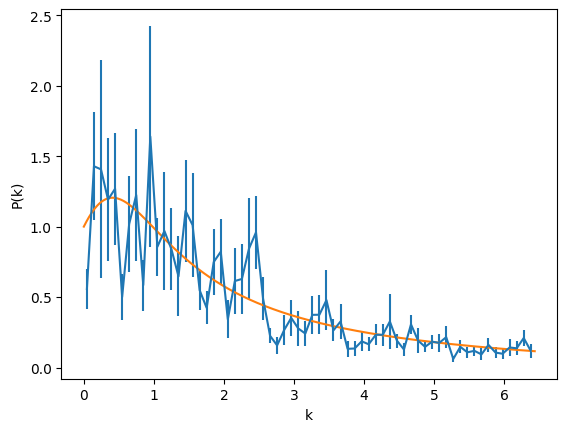

In [20]:
# specify how many points we want to rebin
Nrebin=2**3
bin_k,bin_Pk,bin_var_Pk = binned_power(k,abs(modes)**2,Nrebin)
plt.errorbar(bin_k,bin_Pk,yerr=np.sqrt(bin_var_Pk))
plt.plot(k,true_p1d(k))
plt.xlabel('k')
plt.ylabel('P(k)')

### Run on multiple skewers

In [21]:
# generate many random fields
Nsk=1000000
gen = np.random.default_rng(seed)

In [22]:
# measure P1D and variance
mean_p1d=np.zeros(NF)
var_p1d=np.zeros(NF)
for i in range(Nsk):
    modes=get_gaussian_modes(gen=gen,debug=False)
    p1d = abs(modes)**2
    mean_p1d += p1d
    var_p1d += p1d**2
# normalize them
mean_p1d /= Nsk
var_p1d /= Nsk
var_p1d -= mean_p1d**2
# compute error on mean
err_p1d = np.sqrt(var_p1d/Nsk)

In [23]:
# evaluate true P1D for the plot
true=true_p1d(k)

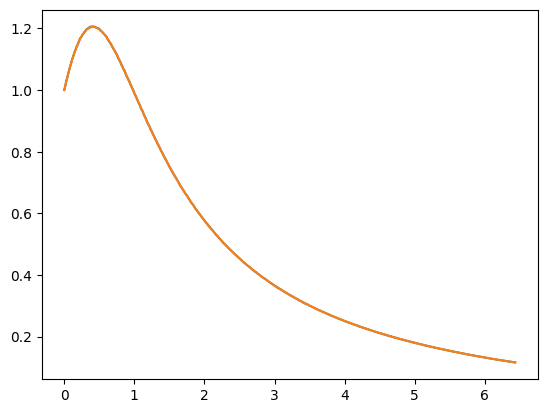

In [24]:
plt.plot(k,mean_p1d)
plt.plot(k,true)

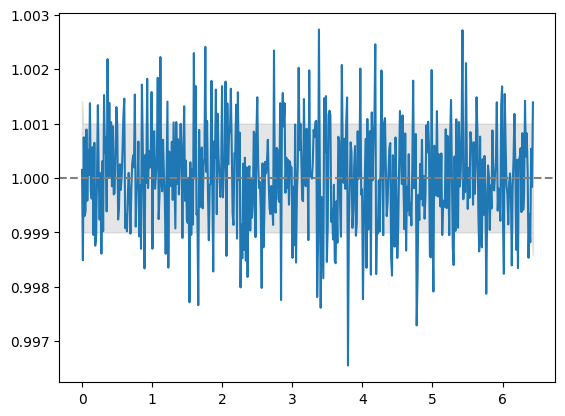

In [25]:
plt.plot(k,mean_p1d/true)
plt.fill_between(k,1-err_p1d/true,1+err_p1d/true,alpha=0.2,color='gray')
plt.axhline(y=1,ls='--',color='gray')

### Apply a mask (same for all skewers) and redo the plots

In [26]:
mask=np.ones(N)
# will mask a small fraction of the data
Nbad=N//10
mask[Nbad:2*Nbad]=0
mask[6*Nbad:7*Nbad]=0

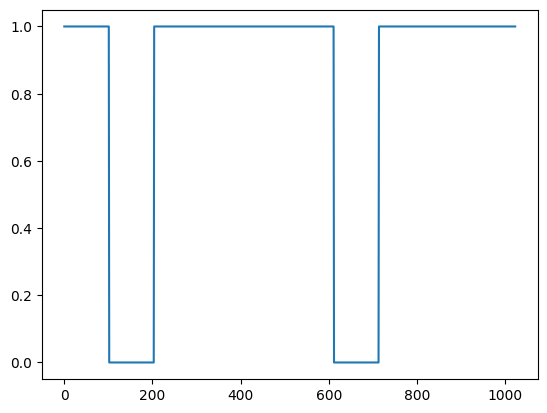

In [27]:
plt.plot(mask)

In [28]:
# FFT the mask, and square it
w_m = get_modes(mask)
w2_m = abs(w_m)**2

(0.0, 0.5)

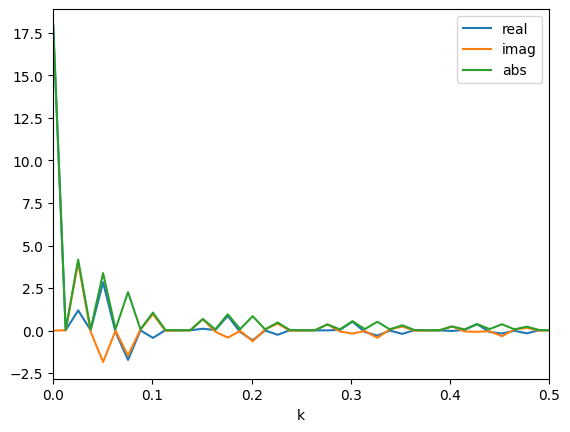

In [29]:
plt.plot(k,w_m.real,label='real')
plt.plot(k,w_m.imag,label='imag')
plt.plot(k,np.sqrt(w2_m),label='abs')
plt.legend()
plt.xlabel('k')
plt.xlim([0,0.5])

In [30]:
# reset seed again
gen = np.random.default_rng(seed)
# measure P1D and variance
mean_masked_p1d=np.zeros(NF)
var_masked_p1d=np.zeros(NF)
for i in range(Nsk):
    # recompute modes
    modes=get_gaussian_modes(gen=gen,debug=False)    
    # FFT the modes to obtain the skewers
    deltas = get_field(modes)
    # mask the skewers
    deltas *= mask
    # and FFT again to obtain masked modes
    masked_modes=get_modes(deltas)
    p1d = abs(masked_modes)**2
    mean_masked_p1d += p1d
    var_masked_p1d += p1d**2
# normalize them
mean_masked_p1d /= Nsk
var_masked_p1d /= Nsk
var_masked_p1d -= mean_masked_p1d**2
# compute error on mean
err_masked_p1d = np.sqrt(var_masked_p1d/Nsk)

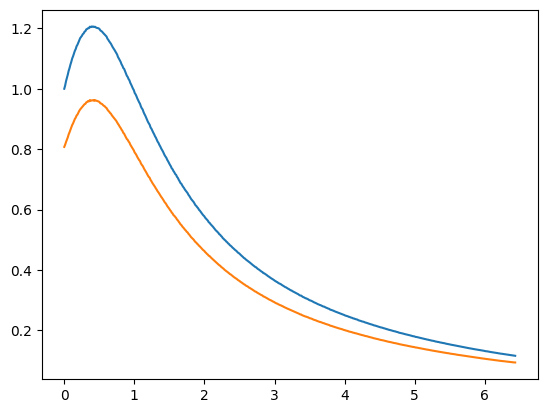

In [31]:
plt.plot(k,mean_p1d)
plt.plot(k,mean_masked_p1d)

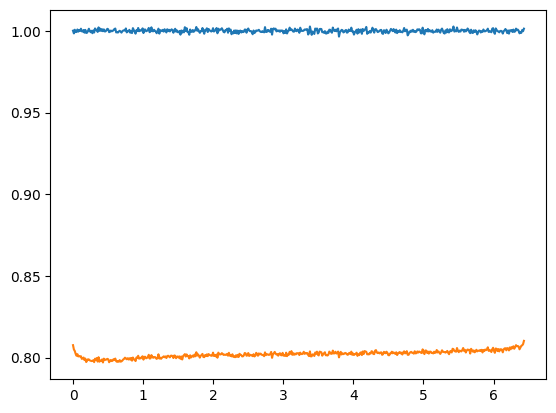

In [32]:
plt.plot(k,mean_p1d/true)
plt.plot(k,mean_masked_p1d/true)

In [33]:
norm=np.mean(mean_masked_p1d/mean_p1d)
print(norm)

0.8020677073796068


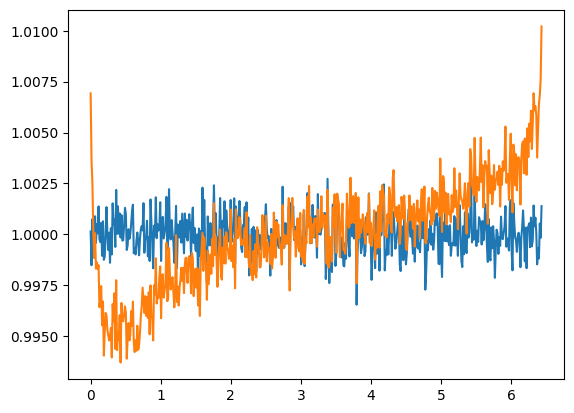

In [34]:
plt.plot(k,mean_p1d/true)
plt.plot(k,mean_masked_p1d/true/norm)

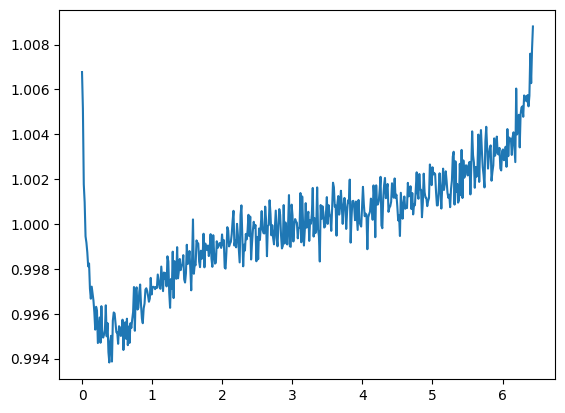

In [35]:
plt.plot(k,mean_masked_p1d/mean_p1d/norm)

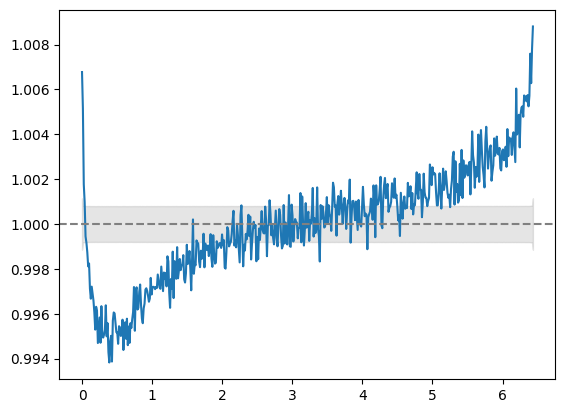

In [36]:
plt.plot(k,mean_masked_p1d/mean_p1d/norm)
plt.fill_between(k,1-err_masked_p1d/true,1+err_masked_p1d/true,alpha=0.2,color='gray')
plt.axhline(y=1,ls='--',color='gray')